### Pre-requesties

In [2]:
import os
import re
import ast
import string
import tarfile
import requests
import zipfile
import pandas as pd
import numpy as np
import collections
import logging
import warnings
import tensorflow as tf
import tensorflow_datasets as tfds
import gensim
import nltk
from tempfile import NamedTemporaryFile
from bs4 import BeautifulSoup
from keras import layers
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from gensim import corpora
from transformers import logging as transformers_logging
from transformers import TFDistilBertModel, AutoTokenizer
import spacy

/opt/homebrew/anaconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
# Configure warnings and logging
warnings.filterwarnings("ignore")
transformers_logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tf.get_logger().setLevel(logging.ERROR)

#### Hypotheses

#### Main Hypotheses:

- Null Hypothesis (H0): Words in tweets and profiles do not have a significant effect on predicting user gender (i.e., the predictive power is random or weak).
- Alternative Hypothesis (H1): Words in tweets and profiles have a significant effect on predicting user gender (i.e., they provide strong predictive power).

#### Additional Hypotheses:
- H0: Other factors ('retweet_count', 'fav_number', 'description', 'text', 'tweet_count') are not good predictors of gender.
- H1: Other factors ('retweet_count', 'fav_number', 'description', 'text', 'tweet_count') can strongly predict gender.

### Data Preperation, Visulization

In [6]:
class Setup:
    """Class to Setup"""
    def __init__(self):
        self.setup_nltk()
        self.setup_gpu()

    @staticmethod
    def setup_nltk():
        """Download necessary NLTK datasets"""
        nltk.download('averaged_perceptron_tagger', download_dir='/opt/homebrew/anaconda3/envs/py312/nltk_data')
        nltk.download('punkt', download_dir='/opt/homebrew/anaconda3/envs/py312/nltk_data')
        nltk.download('stopwords', download_dir='/opt/homebrew/anaconda3/envs/py312/nltk_data')
        nltk.download('wordnet', download_dir='/opt/homebrew/anaconda3/envs/py312/nltk_data')
        nltk.download('brown', download_dir='/opt/homebrew/anaconda3/envs/py312/nltk_data')

    @staticmethod
    def setup_gpu():
        """Set up GPU configuration."""
        pass

    @staticmethod
    def section(text,n=20):
        """section text"""
        print()
        print("-"*n)
        print(text)
        print("-"*n)
        print()


In [7]:
class TextProcessor:
    """Class to process text"""
    def __init__(self):
        self.remove_words = set([
            "im", "tweet", "like", "follow", "rt", "dm", "pm",
            "#", "@", "followfriday", "ff", "l4l", "boost", "promo", "deal", "win",
            "now", "today", "tomorrow", "free", "best"
        ])
        self.stopwords_set = set(stopwords.words('english')).union(self.remove_words)
        self.lemmatizer = WordNetLemmatizer()
        self.nlp = spacy.load("en_core_web_sm")
        self.vectorizer = CountVectorizer()

    def word_cloud(self, texts):
      """Plot word cloud for text"""
      text = ' '.join(texts)
      wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
      plt.figure(figsize=(8, 8), facecolor=None)
      plt.imshow(wordcloud)
      plt.axis("off")
      plt.tight_layout(pad=0)
      plt.show()

    def denoise_text(self, text):
        """Remove unwanted characters and format text."""
        text = self.remove_whitespace(text)
        text = self.remove_html(text)
        text = self.remove_between_square_brackets(text)
        text = self.remove_url(text)
        text = self.remove_special_characters(text)
        text = self.remove_punctuation(text)
        text = self.remove_hashtags(text)
        return text

    def standardize_text(self, text):
        """Convert text to lowercase."""
        return text.lower()

    def denoise_and_standardize_and_lemmatize_text(self, text):
        """Apply denoise and standardize functions"""
        return self.lemmatize(self.standardize_text(self.denoise_text(text)))

    def lemmatize(self, text):
        """Lemmatize text, excluding all stopwords."""
        tokens = word_tokenize(text)
        return ' '.join([self.lemmatizer.lemmatize(word) for word in tokens if word not in self.stopwords_set])


    # Bag of Words Models
    def vectorize(self, texts):
        """Vectorize text"""
        X = self.vectorizer.fit_transform(texts)
        feature_names = self.vectorizer.get_feature_names_out()
        dense_array = X.toarray()
        return dense_array, feature_names

    # Word2Vec
    def embeddings(self, texts):
        """Embeddings"""
        sentences = [text.split() for text in texts]
        model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
        return model

    def get_average_embedding(self, sentence, model):
        """Get average embedding"""
        embeddings = [model.wv[word] for word in sentence.split()]
        if len(embeddings) == 0:
            return np.zeros(model.vector_size)
        return np.mean(embeddings, axis=0)

    @staticmethod
    def remove_whitespace(text):
        """Remove Whitespace"""
        return re.sub(r'\s+', ' ', text).strip()

    @staticmethod
    def remove_html(text):
        """Remove HTML"""
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    @staticmethod
    def remove_between_square_brackets(text):
        """Remove Brackets"""
        return re.sub('\[[^]]*\]', '', text)

    @staticmethod
    def remove_url(text):
        """Remove Url"""
        return re.sub(r"(?:\@|https?\://)\S+", '', text)

    @staticmethod
    def remove_special_characters(text):
        """Remove Special Characters"""
        pattern = r'[^a-zA-Z0-9\s]'
        return re.sub(pattern, '', text)

    @staticmethod
    def remove_punctuation(text):
        """Remove Punctuation"""
        translator = str.maketrans('', '', string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§')
        return text.translate(translator)

    @staticmethod
    def remove_hashtags(text):
        """Remove Hashtags"""
        text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
        text = " ".join(word.strip() for word in re.split('#|_', text))
        return text

In [8]:
class Task1:
    def __init__(self, base_path, file):
        self.base_path = base_path
        self.file = file
        self.df = None
        self.scaler = StandardScaler()
        self.le_gender = LabelEncoder()

    def load_data(self):
      """load data"""
      self.df = pd.read_csv(os.path.join(self.base_path, self.file), encoding='latin1')

    def encode_labels(self, df):
        """Encode labels"""
        print("Encoding Gender and Brand")
        df['gender'] = df['gender'].replace({'male': 'human', 'female': 'human'})
        df['gender'] = df['gender'].replace({'brand': 'non-human'})
        df['gender'] = self.le_gender.fit_transform(df['gender'])
        return df

    def scale_features(self, df):
        """Scale numeric features using StandardScaler"""
        print("Applying Standard Scaler")
        columns_to_scale = ['fav_number','retweet_count','tweet_count']
        numerical = df[columns_to_scale]
        scaled_features = self.scaler.fit_transform(numerical)
        scaled_features_df = pd.DataFrame(
            scaled_features, columns=columns_to_scale, index=df.index)
        df[columns_to_scale] = scaled_features_df

        return df

    def preprocess_data_frame(self):
        """Select features, fill missing values, scale features, encode labels"""
        print("Selecting rows with high gender confidence")
        df = self.df.copy()
        df = df[df['gender'].isin(['female','male','brand'])]
        df = df[df['gender:confidence'] > 0.9]

        chosen_columns = {
            'gender', 'fav_number', 'retweet_count','text','tweet_count'
        }

        print(f"Selecting features: {chosen_columns}")
        df = df.loc[:, self.df.columns.intersection(chosen_columns)]

        print("Filling missing values")
        df.fillna('', inplace=True)


        print("Scaling features")
        df = self.scale_features(df)

        print("Encoding Labels")
        df = self.encode_labels(df)

        return df

    def plot_correlation_matrix(self, df, alpha=0.05):
        """Plot the correlation matrix"""

        df = df.select_dtypes(include=['int64', 'float64'])
        correlation_matrix = df.corr()

        # Initialize a DataFrame to store p-values
        p_values = pd.DataFrame(np.zeros_like(
            correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)

        # Calculate p-values
        for row in correlation_matrix.index:
            for col in correlation_matrix.index:
                if row == col:
                    # p-value is 0 for diagonal elements
                    p_values.loc[row, col] = 0.0
                else:
                    _, p_val = stats.pearsonr(df[row], df[col])

                    p_values.loc[row, col] = p_val

        # Create a mask for significant correlations
        significant_mask = p_values < alpha

        # Plot the correlation matrix with a mask
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=~significant_mask,
                    cbar_kws={"label": "Correlation Coefficient"}, annot_kws={"size": 10})

        plt.title('Significant Correlations')
        plt.show()

        return correlation_matrix, p_values

    def plot_pairplot(self, df):
        """Plot the scatterplot matrix"""
        df = df.select_dtypes(include=['int64', 'float64'])
        sns.pairplot(df)
        plt.suptitle('Scatterplot Matrix', y=1.02)  # Add a title
        plt.show()

In [9]:
"""main function"""
Setup.section("Assignment 2 - Group 17")

Setup.setup_nltk()


--------------------
Assignment 2 - Group 17
--------------------



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /opt/homebrew/anaconda3/envs/py312/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /opt/homebrew/anaconda3/envs/py312/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /opt/homebrew/anaconda3/envs/py312/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /opt/homebrew/anaconda3/envs/py312/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /opt/homebrew/anaconda3/envs/py312/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [10]:
Setup.section("Task 1 - Data Preparation")

base_path = r'.'
file = "twitter_user_data.csv"
task1 = Task1(base_path, file)
task1.load_data()
df_preprocessed = task1.preprocess_data_frame()


--------------------
Task 1 - Data Preparation
--------------------

Selecting rows with high gender confidence
Selecting features: {'retweet_count', 'text', 'tweet_count', 'fav_number', 'gender'}
Filling missing values
Scaling features
Applying Standard Scaler
Encoding Labels
Encoding Gender and Brand


In [11]:
df_preprocessed['gender'].value_counts()

gender
0    10023
1     3787
Name: count, dtype: int64

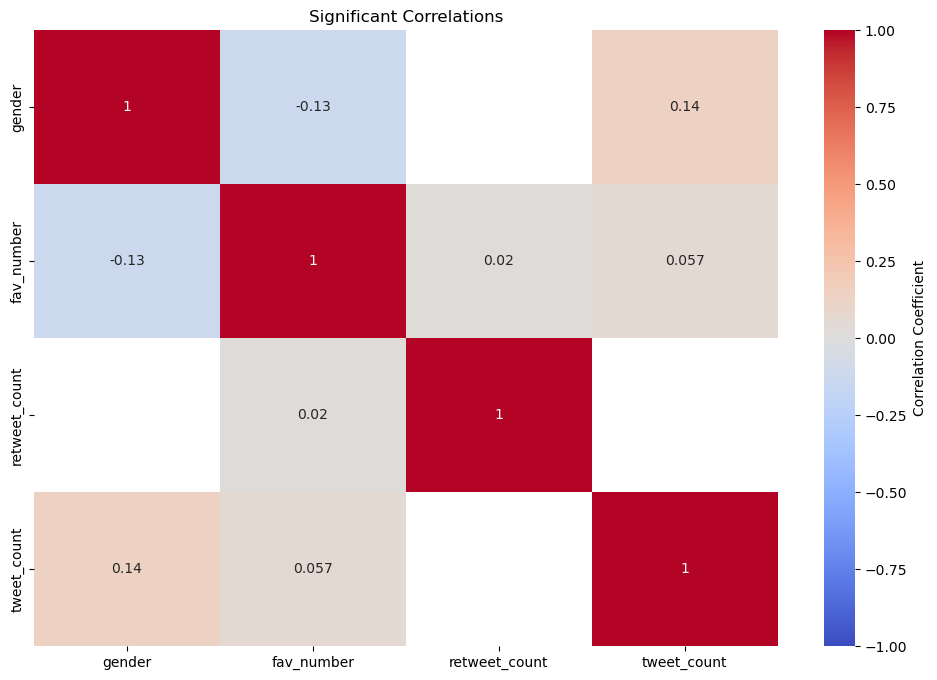

In [12]:
_, p_values = task1.plot_correlation_matrix(df_preprocessed)

In [13]:
print("P values for twitter data")
p_values

P values for twitter data


,gender,fav_number,retweet_count,tweet_count
gender,0.000000e+00,8.695484e-55,0.861881,1.074486e-60
fav_number,8.695484e-55,0.000000e+00,0.017874,2.134321e-11
retweet_count,8.618808e-01,1.787372e-02,0.000000,9.691600e-01
tweet_count,1.074486e-60,2.134321e-11,0.969160,0.000000e+00


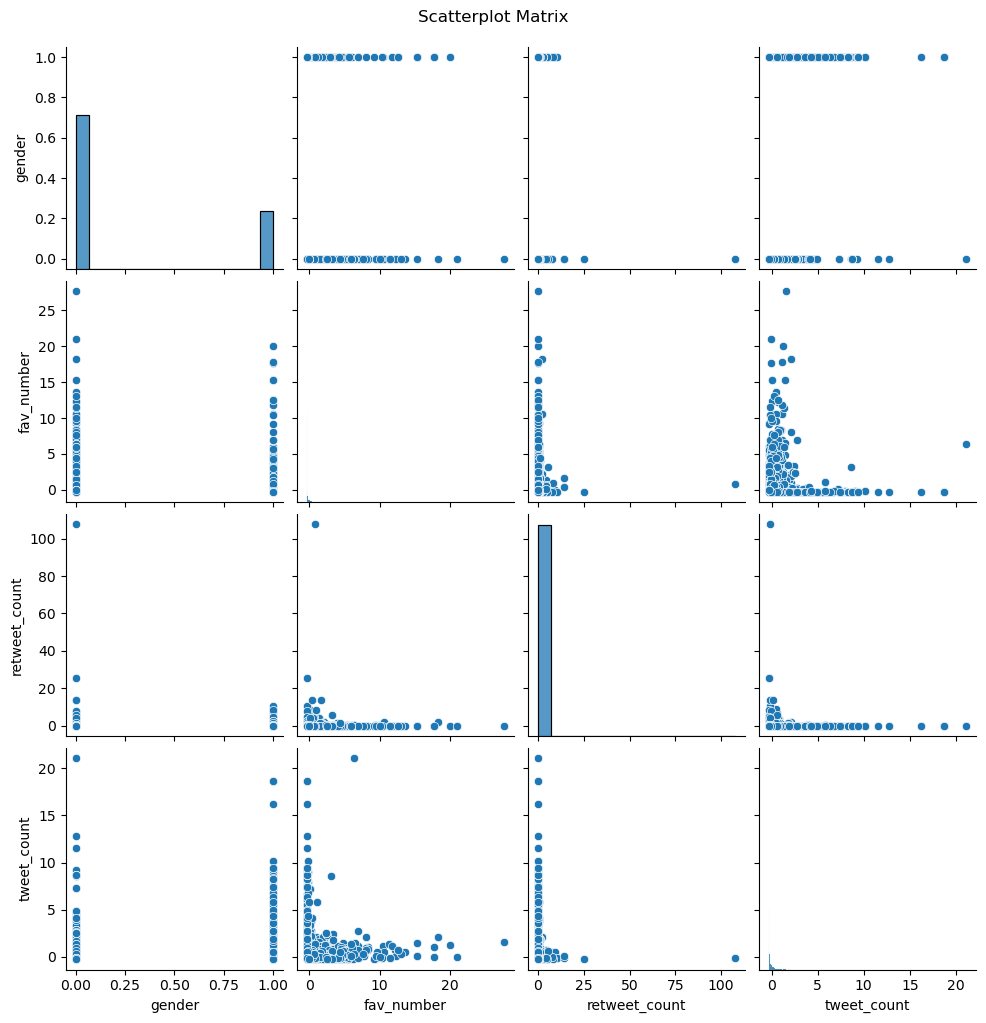

In [14]:
task1.plot_pairplot(df_preprocessed)

In [15]:
print(nltk.data.path)

['/Users/baninss/nltk_data', '/opt/homebrew/anaconda3/envs/py312/nltk_data', '/opt/homebrew/anaconda3/envs/py312/share/nltk_data', '/opt/homebrew/anaconda3/envs/py312/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [16]:
text_processor = TextProcessor()
df_preprocessed['text'] = df_preprocessed['text'].apply(text_processor.denoise_and_standardize_and_lemmatize_text)

Word cloud for tweet


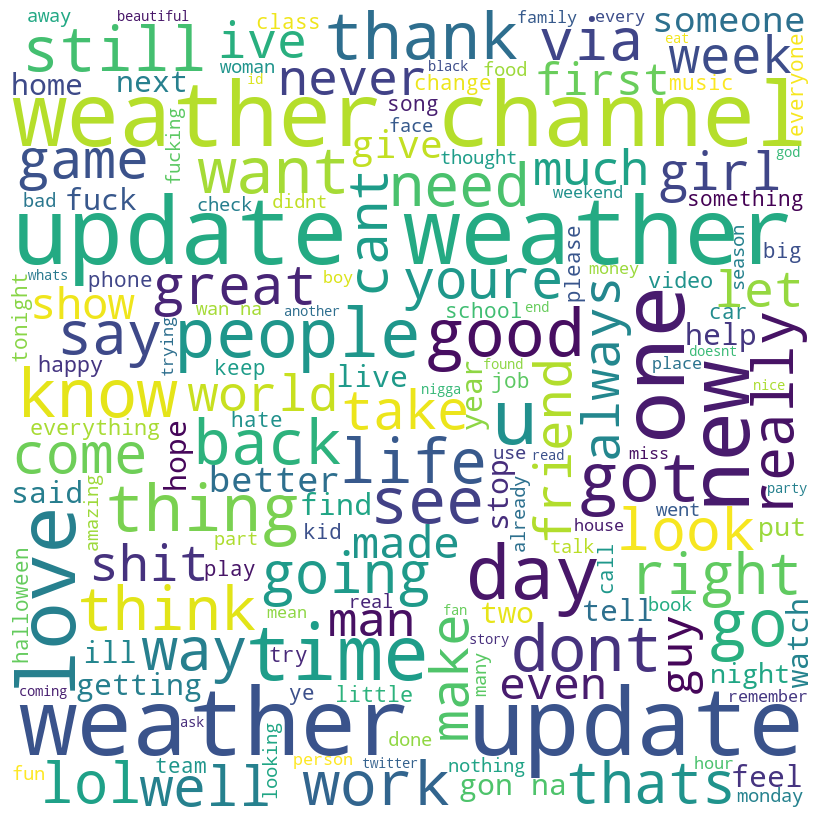

In [17]:
print("Word cloud for tweet")
text_processor.word_cloud(df_preprocessed['text'].ravel())

In [18]:
## BAG OF WORDS MODLE
bow_dense_array, bow_feature_names = text_processor.vectorize(df_preprocessed['text'])
df_preprocessed['bow_feature'] = bow_dense_array.tolist()

In [19]:
### Word2Vec
model = text_processor.embeddings(df_preprocessed['text'])
word2vec_embeddings = [text_processor.get_average_embedding(text, model) for text in df_preprocessed['text']]

In [20]:
df_preprocessed['word2vec_embeddings'] = word2vec_embeddings

### Clustering

In [21]:
#### Use the df_preprocessed to perform clustering, I have applied the bag of words and word2vec model on user tweet
df_preprocessed.head()

,gender,fav_number,retweet_count,text,tweet_count,bow_feature,word2vec_embeddings
0,0,-0.348345,-0.047969,robbie e responds critic eddie edward worldtit...,0.582729,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04136858, -0.023947818, 0.021651521, -0.007..."
1,0,-0.342754,-0.047969,felt friend living story retired ian1,-0.244501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2192703, -0.12080341, 0.10868588, -0.028353..."
3,0,-0.331736,-0.047969,hi looking url use dont typically see advanced...,-0.290685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.37485355, -0.21837068, 0.17542821, -0.04990..."
4,0,2.719920,-0.047969,watching neighbour sky catching neighbs xxx xxx,-0.052738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.07355917, -0.040629167, 0.041307896, -0.005..."
5,0,-0.027607,-0.047969,ive seen people train lamp chair tv etc,-0.144067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.32012936, -0.18986961, 0.1554443, -0.041876..."


### Classification

In [22]:
#### Use the df_preprocessed to perform classification, I have applied the bag of words and word2vec model on user tweet, the target is gender
df_preprocessed.head()

,gender,fav_number,retweet_count,text,tweet_count,bow_feature,word2vec_embeddings
0,0,-0.348345,-0.047969,robbie e responds critic eddie edward worldtit...,0.582729,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04136858, -0.023947818, 0.021651521, -0.007..."
1,0,-0.342754,-0.047969,felt friend living story retired ian1,-0.244501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2192703, -0.12080341, 0.10868588, -0.028353..."
3,0,-0.331736,-0.047969,hi looking url use dont typically see advanced...,-0.290685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.37485355, -0.21837068, 0.17542821, -0.04990..."
4,0,2.719920,-0.047969,watching neighbour sky catching neighbs xxx xxx,-0.052738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.07355917, -0.040629167, 0.041307896, -0.005..."
5,0,-0.027607,-0.047969,ive seen people train lamp chair tv etc,-0.144067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.32012936, -0.18986961, 0.1554443, -0.041876..."


Best Decision Tree Params: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Accuracy: 0.8073859522085446
F1 Score: 0.7960163364022558
Recall: 0.8073859522085446


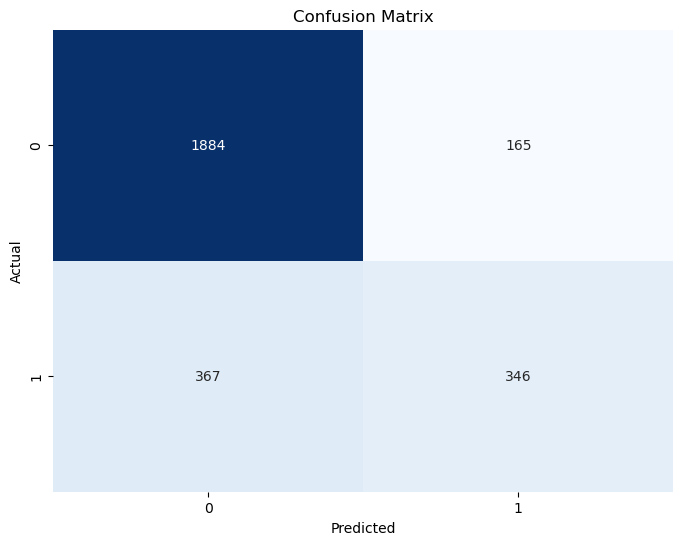

In [23]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class ModelBase:
    def __init__(self, df_preprocessed):
        self.df = df_preprocessed
        self.X_train, self.X_test, self.y_train, self.y_test = self.prepare_data()

    def prepare_data(self):
        """Prepare data by splitting into features and labels, and then into train/test sets."""
        # Separate features and target
        X = self.df.drop(columns='gender')  # Assuming 'gender' is the label
        y = self.df['gender']

        # Flatten the `bow_feature` and `word2vec_embeddings` columns and combine with other numerical features
        X_bow = pd.DataFrame(X['bow_feature'].tolist(), index=X.index)
        X_w2v = pd.DataFrame(X['word2vec_embeddings'].tolist(), index=X.index)
        X.drop(columns=['bow_feature', 'word2vec_embeddings', 'text'], inplace=True)  # Drop unnecessary columns

        # Concatenate the numeric columns and the flattened BOW and Word2Vec features
        X_combined = pd.concat([X, X_bow, X_w2v], axis=1)
        
        # Ensure all feature names are strings
        X_combined.columns = X_combined.columns.astype(str)
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test

    def build_pipeline(self, model):
        """Build a pipeline for scaling numeric features and applying the model."""
        # Standard scaling for numerical features
        pipeline_steps = [
            ('scaler', StandardScaler()),  # Scale all the features
            ('model', model)               # The classifier
        ]
        return Pipeline(pipeline_steps)

    def grid_search_cv(self, pipeline, param_grid):
        """Perform K-fold cross-validation with grid search."""
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')
        grid_search.fit(self.X_train, self.y_train)
        return grid_search.best_estimator_, grid_search.best_params_

    def evaluate(self, model):
        """Evaluate the model on the test data using accuracy, F1, recall, and confusion matrix."""
        y_pred = model.predict(self.X_test)

        accuracy = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        recall = recall_score(self.y_test, y_pred, average='weighted')
        cm = confusion_matrix(self.y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"F1 Score: {f1}")
        print(f"Recall: {recall}")
        self.plot_confusion_matrix(cm)

    @staticmethod
    def plot_confusion_matrix(cm):
        """Plot confusion matrix using seaborn."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


class KNNClassifier(ModelBase):
    def __init__(self, df_preprocessed):
        super().__init__(df_preprocessed)

    def train(self):
        """Train the KNN model with grid search."""
        knn = KNeighborsClassifier()
        pipeline = self.build_pipeline(knn)

        # Define parameter grid for KNN
        param_grid = {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }

        best_model, best_params = self.grid_search_cv(pipeline, param_grid)
        print(f"Best KNN Params: {best_params}")
        self.evaluate(best_model)
        return best_model, best_params


class SVMClassifier(ModelBase):
    def __init__(self, df_preprocessed):
        super().__init__(df_preprocessed)

    def train(self):
        """Train the SVM model with grid search."""
        svm = SVC()
        pipeline = self.build_pipeline(svm)

        # Define parameter grid for SVM
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }

        best_model, best_params = self.grid_search_cv(pipeline, param_grid)
        print(f"Best SVM Params: {best_params}")
        self.evaluate(best_model)
        return best_model, best_params


class DecisionTreeClassifierModel(ModelBase):
    def __init__(self, df_preprocessed):
        super().__init__(df_preprocessed)

    def train(self):
        """Train the Decision Tree model with grid search."""
        dt = DecisionTreeClassifier()
        pipeline = self.build_pipeline(dt)

        # Define parameter grid for Decision Tree
        param_grid = {
            'model__max_depth': [3, 5, 7],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }

        best_model, best_params = self.grid_search_cv(pipeline, param_grid)
        print(f"Best Decision Tree Params: {best_params}")
        self.evaluate(best_model)
        return best_model, best_params


class RandomForestClassifierModel(ModelBase):
    def __init__(self, df_preprocessed):
        super().__init__(df_preprocessed)

    def train(self):
        """Train the Random Forest model with grid search."""
        rf = RandomForestClassifier()
        pipeline = self.build_pipeline(rf)

        # Define parameter grid for Random Forest
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [3, 5, 7],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }

        best_model, best_params = self.grid_search_cv(pipeline, param_grid)
        print(f"Best Random Forest Params: {best_params}")
        self.evaluate(best_model)
        return best_model, best_params


# Example usage with df_preprocessed
knn_classifier = KNNClassifier(df_preprocessed)
best_knn_model, knn_params = knn_classifier.train()

svm_classifier = SVMClassifier(df_preprocessed)
best_svm_model, svm_params = svm_classifier.train()

dt_classifier = DecisionTreeClassifierModel(df_preprocessed)
best_dt_model, dt_params = dt_classifier.train()

rf_classifier = RandomForestClassifierModel(df_preprocessed)
best_rf_model, rf_params = rf_classifier.train()



### Regression

In [ ]:
#### Use the df_preprocessed to perform regression, try to use fav_number, retweet, tweetCount
df_preprocessed.head()

,gender,fav_number,retweet_count,text,tweet_count,bow_feature,word2vec_embeddings
0,0,-0.348345,-0.047969,robbie e responds critic eddie edward worldtit...,0.582729,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.040056627, -0.022863982, 0.023303276, -0.00..."
1,0,-0.342754,-0.047969,felt friend living story retired ian1,-0.244501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.20822506, -0.11259735, 0.114053994, -0.0198..."
3,0,-0.331736,-0.047969,hi looking url use dont typically see advanced...,-0.290685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.36056155, -0.20923084, 0.18390644, -0.03826..."
4,0,2.719920,-0.047969,watching neighbour sky catching neighbs xxx xxx,-0.052738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06560795, -0.035533745, 0.04100291, -0.0021..."
5,0,-0.027607,-0.047969,ive seen people train lamp chair tv etc,-0.144067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.3072857, -0.18076485, 0.1636882, -0.0310424..."


### Deep Learning

In [ ]:
#### Use the df_preprocessed to perform deep learning, for this embedding should be suffitiendt
df_preprocessed.head()

,gender,fav_number,retweet_count,text,tweet_count,bow_feature,word2vec_embeddings
0,0,-0.348345,-0.047969,robbie e responds critic eddie edward worldtit...,0.582729,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.040056627, -0.022863982, 0.023303276, -0.00..."
1,0,-0.342754,-0.047969,felt friend living story retired ian1,-0.244501,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.20822506, -0.11259735, 0.114053994, -0.0198..."
3,0,-0.331736,-0.047969,hi looking url use dont typically see advanced...,-0.290685,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.36056155, -0.20923084, 0.18390644, -0.03826..."
4,0,2.719920,-0.047969,watching neighbour sky catching neighbs xxx xxx,-0.052738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06560795, -0.035533745, 0.04100291, -0.0021..."
5,0,-0.027607,-0.047969,ive seen people train lamp chair tv etc,-0.144067,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.3072857, -0.18076485, 0.1636882, -0.0310424..."
